# Configure Phenotype Process Params

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## SET PARAMETERS

### Fixed parameters for SBS processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from microfilm import microplot
from microfilm.microplot import Micropanel

from lib.shared.configuration_utils import random_cmap, CONFIG_FILE_HEADER
from lib.shared.file_utils import get_filename, read_stack
from lib.shared.illumination_correction import apply_ic_field
from lib.shared.segment_cellpose import segment_cellpose
from lib.shared.segment_cellpose import estimate_diameters
from lib.phenotype_process.configuration_utils import annotate_on_phenotyping_data
from lib.phenotype_process.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.shared.extract_phenotype_minimal import extract_phenotype_minimal
from lib.phenotype_process.eval_mapping import plot_count_heatmap

## SET PARAMETERS

### Parameters for testing SBS processing

- `TEST_WELL`, `TEST_TILE`: Well/tile combination used for configuring parameters in this notebook.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.

In [3]:
# parameters for testing
TEST_WELL = "A1"
TEST_TILE = 1
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

# parameters for feature extraction
FOCI_CHANNEL = 2
CHANNEL_NAMES = ["dapi", "coxiv", "cenpa", "wga"]

Loading test image...
Applying illumination correction...
Example corrected image:


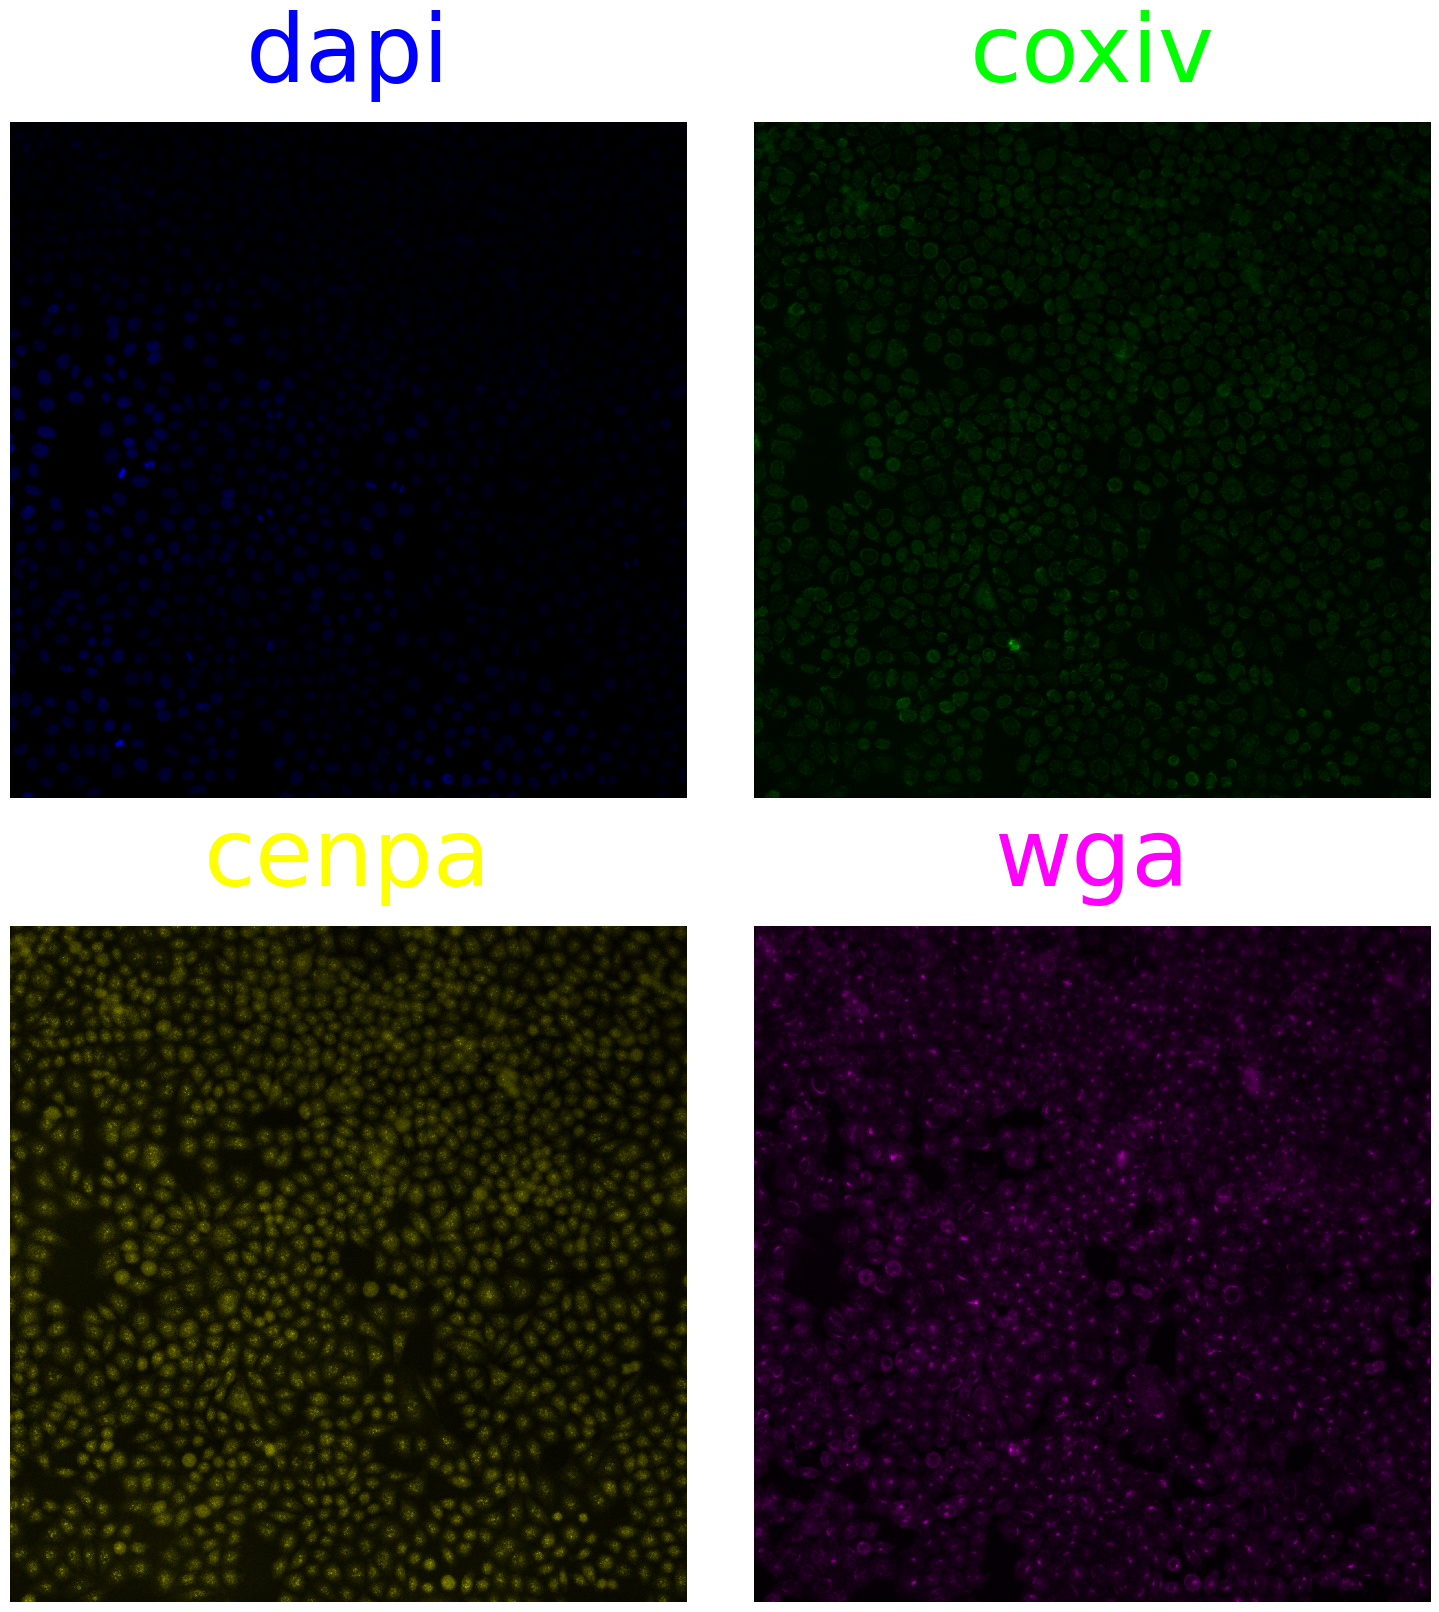

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = read_stack(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = read_stack(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# show corrected
print("Example corrected image:")
ph0_microshow = microplot.Microimage(
    corrected_image[0], cmaps="pure_blue", channel_names=CHANNEL_NAMES[0]
)
ph1_microshow = microplot.Microimage(
    corrected_image[1], cmaps="pure_green", channel_names=CHANNEL_NAMES[1]
)
ph2_microshow = microplot.Microimage(
    corrected_image[2], cmaps="pure_yellow", channel_names=CHANNEL_NAMES[2]
)
ph3_microshow = microplot.Microimage(
    corrected_image[3], cmaps="pure_magenta", channel_names=CHANNEL_NAMES[3]
)
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0, 0], ph0_microshow)
panel.add_element([0, 1], ph1_microshow)
panel.add_element([1, 0], ph2_microshow)
panel.add_element([1, 1], ph3_microshow)
panel.add_channel_label()
plt.show()

## SET PARAMETERS

### Segmentation

- `DAPI_INDEX`: The index of the DAPI channel in your image stack (0-indexed). Typically 0 for the DAPI channel from sequencing.
- `CYTO_CHANNEL`: The index of the cytoplasmic channel in your image stack (0-indexed). Typically the channel that best outlines cell boundaries, usually base C.
- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

In [5]:
# Parameters for CellPose segmentation
DAPI_INDEX = 0
CYTO_CHANNEL = 1

In [6]:
CYTO_MODEL = "cyto3"

In [7]:
print("Estimating optimal cell and nuclei diameters")
NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
    corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_CHANNEL,
    cyto_model=CYTO_MODEL,
)

Estimating optimal cell and nuclei diameters


/lab/barcheese01/miniconda3/envs/brieflow_configuration/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


Estimating nuclei diameters...


/lab/barcheese01/miniconda3/envs/brieflow_configuration/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict =

Estimated nuclear diameter: 40.9 pixels
Estimating cell diameters...
Estimated cell diameter: 52.6 pixels


Segmenting cells...


found 1239 nuclei before removing edges
found 1211 cells before removing edges


removing edges


found 1164 nuclei before reconciling
found 1127 cells before reconciling


reconciling masks with method how=consensus


found 1083 nuclei/cells after reconciling


Number of nuclei segmented: 1083
Number of cells segmented: 1083
Example microplots for DAPI channel and nuclei segmentation:


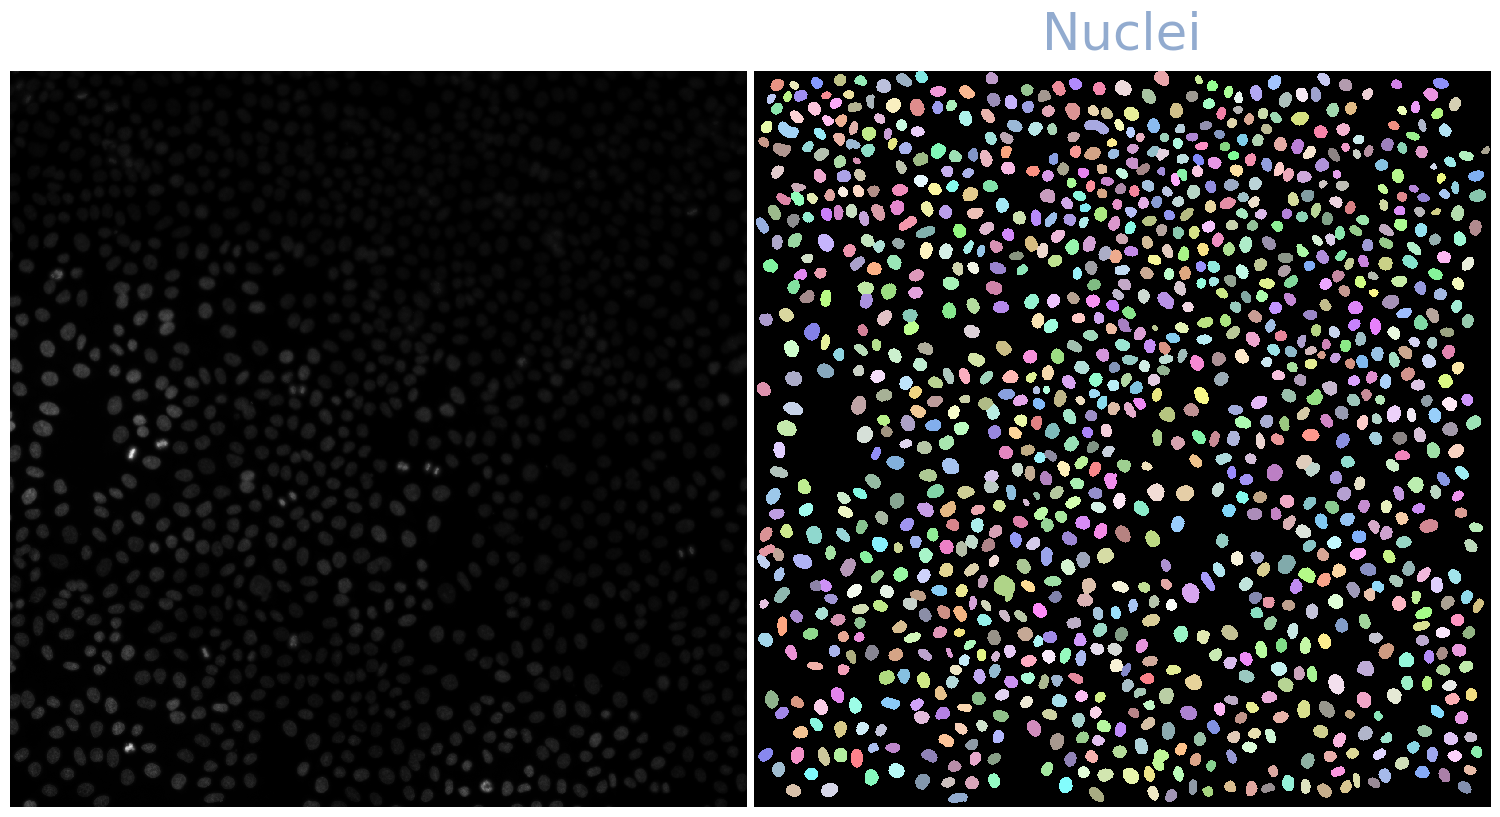

Example microplots for merged channels and cells segmentation:


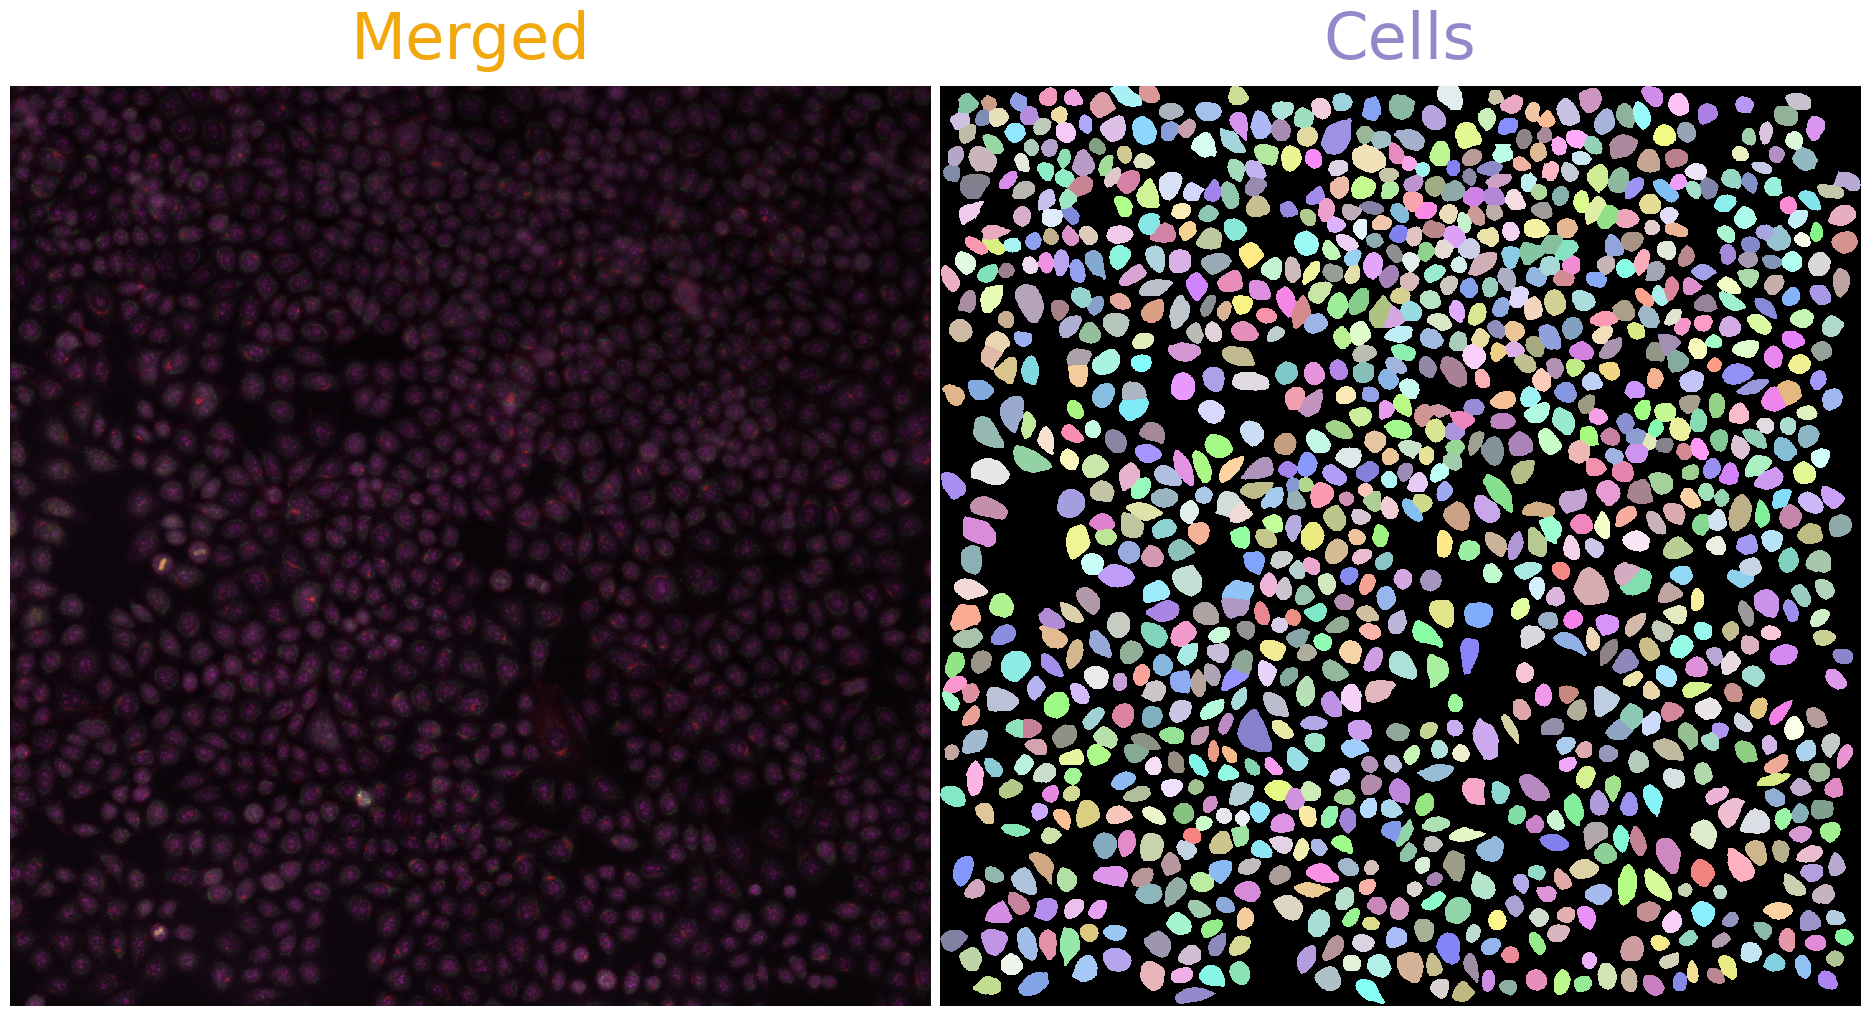

Example microplot for phenotype data annotated with segmenation:


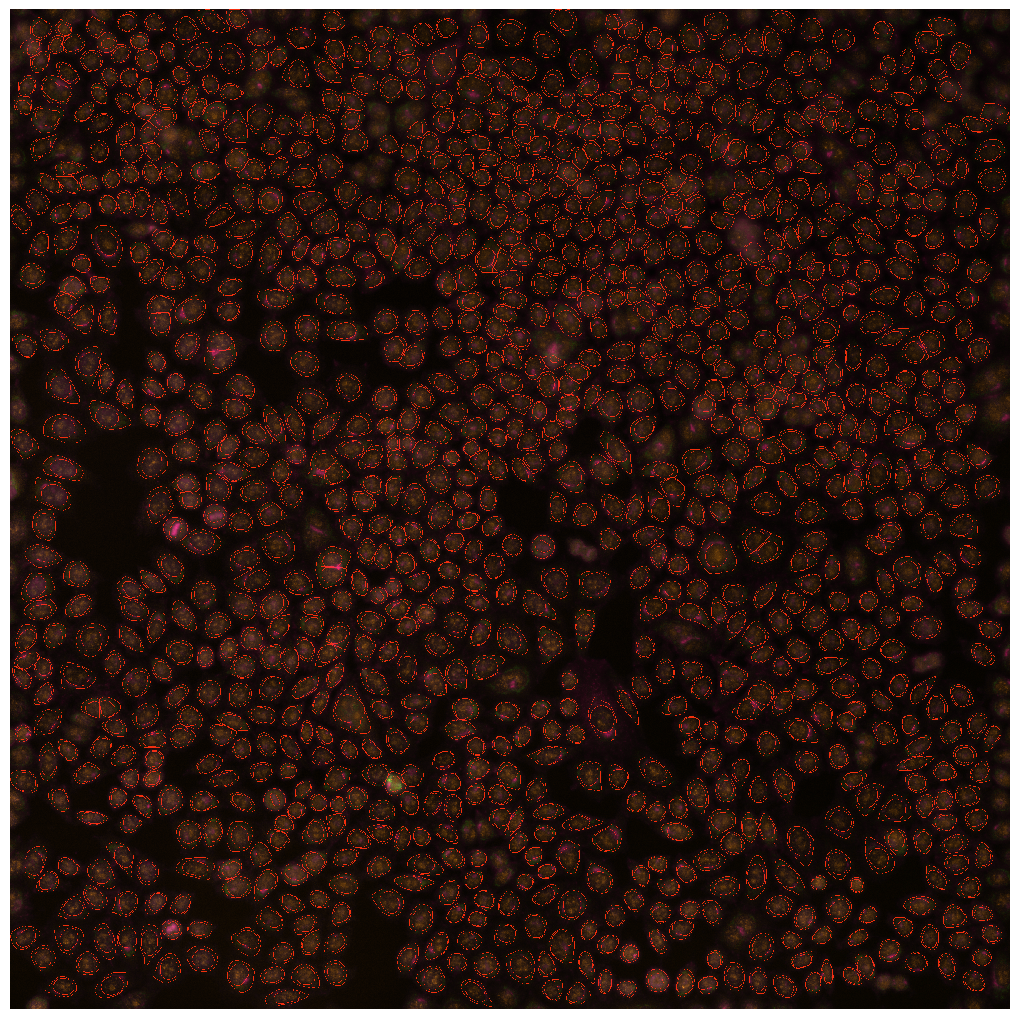

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 1083


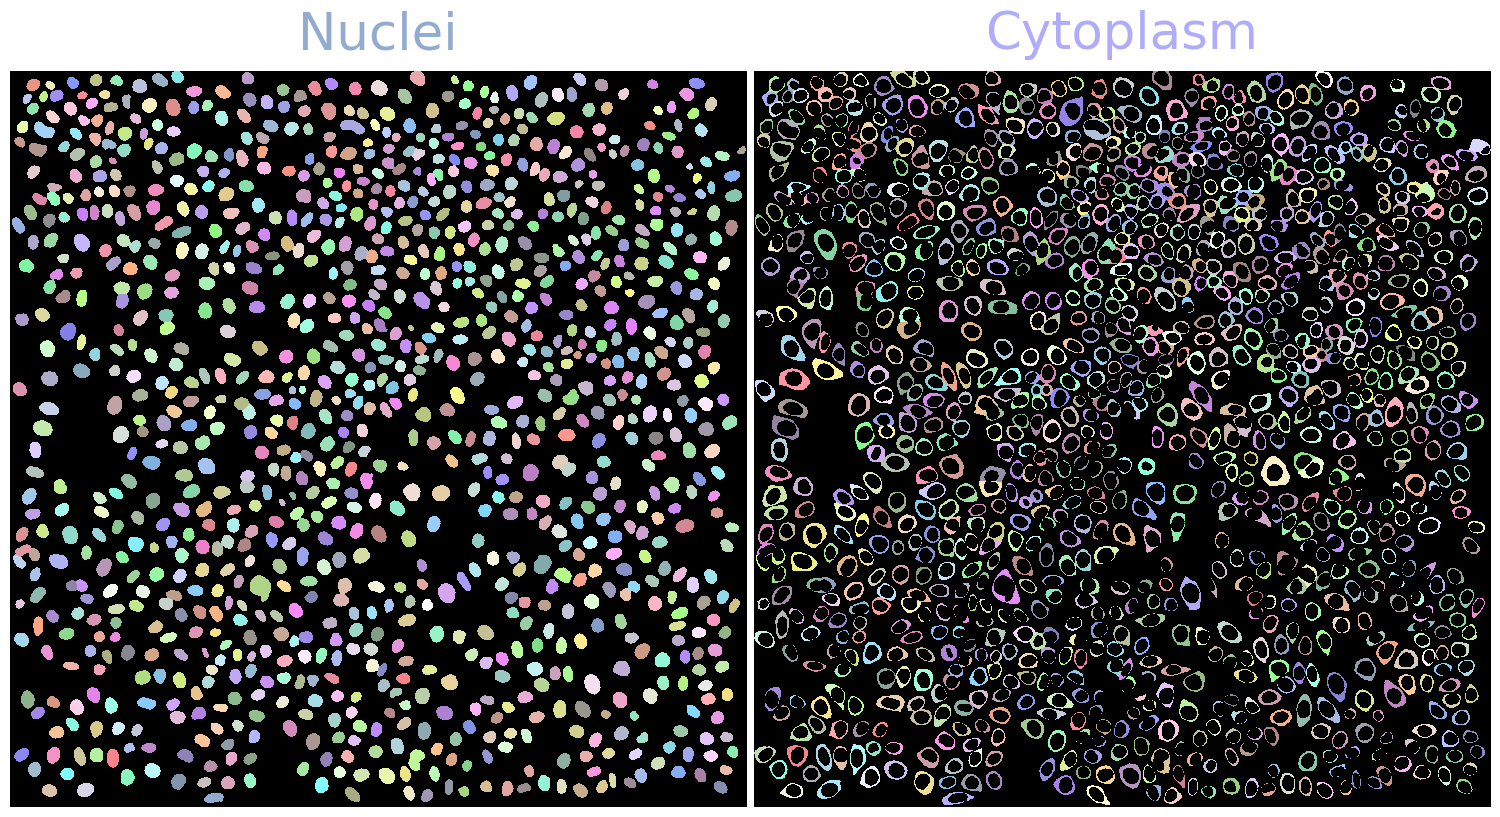

In [8]:
print("Segmenting cells...")
nuclei, cells = segment_cellpose(
    data=corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_CHANNEL,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cyto_model=CYTO_MODEL,
)

print("Example microplots for DAPI channel and nuclei segmentation:")
dapi_microshow = microplot.Microimage(corrected_image[DAPI_INDEX], channel_names="Dapi")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(
    nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], dapi_microshow)
panel.add_element([0, 1], nuclei_microshow)
panel.add_channel_label()
plt.show()

print("Example microplots for merged channels and cells segmentation:")
all_microshow = microplot.Microimage(corrected_image, channel_names="Merged")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells, cmaps=cells_cmap, channel_names="Cells")
panel = Micropanel(rows=1, cols=2, figscaling=10)
panel.add_element([0, 0], all_microshow)
panel.add_element([0, 1], cells_microshow)
panel.add_channel_label()
plt.show()

print("Example microplot for phenotype data annotated with segmenation:")
annotated_data = annotate_on_phenotyping_data(corrected_image, nuclei, cells)
annotated_microshow = microplot.Microimage(annotated_data, channel_names="Merged")
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0, 0], annotated_microshow)
plt.show()

print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasm_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasm_microshow = microplot.Microimage(
    cytoplasms, cmaps=cytoplasm_cmap, channel_names="Cytoplasm"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], nuclei_microshow)
panel.add_element([0, 1], cytoplasm_microshow)
panel.add_channel_label()
plt.show()

In [9]:
print("Minimal extracted phenotype features:")
df_ph_info = extract_phenotype_minimal(nuclei, nuclei, wildcards=WILDCARDS)
display(df_ph_info)

print("Cell number summary:")
plot_count_heatmap(df_ph_info, shape="6W_sbs", return_plot=False, return_summary=True)

Minimal extracted phenotype features:


area            i            j  cell                    bounds  tile  \
0     1295.0    22.025483   544.853282     1         (1, 525, 43, 565)     1   
1     1908.0    26.282495  1328.197589     2       (2, 1303, 52, 1353)     1   
2     1282.0    27.287832   774.179407     3         (7, 755, 48, 795)     1   
3     1305.0    29.322605  1855.988506     4       (9, 1835, 52, 1877)     1   
4     1637.0    32.073305   488.498473     5        (10, 462, 54, 517)     1   
...      ...          ...          ...   ...                       ...   ...   
1078  1348.0  2354.049703  1299.669139  1079  (2330, 1281, 2379, 1319)     1   
1079   951.0  2348.920084  1478.050473  1080  (2333, 1458, 2367, 1496)     1   
1080  1718.0  2358.895809  1115.523865  1081  (2334, 1091, 2385, 1142)     1   
1081  1264.0  2362.803006  1357.856804  1082  (2342, 1339, 2385, 1378)     1   
1082  1664.0  2370.260817   664.545072  1083    (2354, 633, 2387, 697)     1   

     well  
0      A1  
1      A1  
2      A1  
3      A1  
4      A1  
...   ...  
1078   A1  
1079   A1  
1080   A1  
1081   A1  
1082   A1  

[1083 rows x 7 columns]

Cell number summary:


well  tile  count
0   A1     1   1083

## Add phenotype process parameters to config file

In [10]:
# Add phenotype_process section
config["phenotype_process"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "dapi_index": DAPI_INDEX,
    "cyto_channel": CYTO_CHANNEL,
    "nuclei_diameter": NUCLEI_DIAMETER,
    "cell_diameter": CELL_DIAMETER,
    "cyto_model": CYTO_MODEL,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)